In [40]:
'''

#Enable GPU for this Exercise.

'''

'\n\n#Enable GPU for this Exercise.\n\n'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import skorch
import numpy as np
# This package is helpful to apply noise to our images
from skimage import util
#If CUDA is available, use CUDA or else default to CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


'''
Import Mnist
'''

train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transforms.ToTensor(),  
    download=True
)

test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    transform=transforms.ToTensor()
)

normalized_train = train_dataset.data / 255
normalized_test = test_dataset.data / 255
X_train = torch.reshape(normalized_train, (normalized_train.shape[0], 1, 28, 28))
X_test = torch.reshape(normalized_test, (normalized_test.shape[0], 1, 28, 28))
y_train = train_dataset.targets
y_test = train_dataset.targets


In [3]:
# create your training sets (X_train_GN) and (X_train_SP)
X_train_GN = util.random_noise(X_train, mode="gaussian", clip=True).astype(np.float32)
X_train_SP = util.random_noise(X_train, mode="s&p")


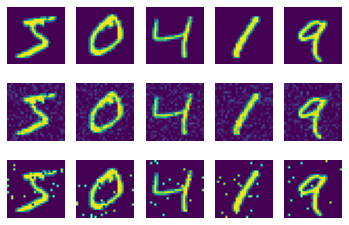

In [43]:

for i, (orig, gaus, sp) in enumerate(zip(X_train[0:5], X_train_GN[0:5], X_train_SP[0:5])):
    plt.subplot(3, 5, i + 1)
    plt.imshow(orig[0])
    plt.axis('off')

    plt.subplot(3, 5, i + 6)
    plt.imshow(gaus[0])
    plt.axis('off')

    plt.subplot(3, 5, i + 11)
    plt.imshow(sp[0])
    plt.axis('off')
    

In [173]:
'''
Create the arquitecture 

'''

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),   
        )
        self.linear = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Unflatten(1, (16, 2, 2)),
        )
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=3, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 6, stride=2, padding=0),
            nn.ReLU(),
        )

    def forward(self, x):
        x, indices = self.encoder(x)
        x = self.linear(x)
        x = self.unpool(x, indices)
        x = self.decoder(x)
        return x

In [215]:

'''
Define your training routine,
your optimizer, your loss function.
Everything you need to train the model
'''

def train(x, y):
    net = skorch.NeuralNet(
        module=Autoencoder,
        device=device,
        criterion=nn.MSELoss,
        optimizer=torch.optim.Adam,
        batch_size=128,
        max_epochs=10,
        lr = .005, 
        # optimizer__weight_decay = 0.001,
    )
    net.fit(x, y)
    return net


In [216]:
# define the netowrk to be train with the salt and peper corrupted images
# train the network
AutoNN_SP = train(X_train_SP, X_train)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0424        0.0334  4.9179
      2        0.0286        0.0276  4.6582
      3        0.0259        0.0260  4.5617
      4        0.0246        0.0247  4.4999
      5        0.0234        0.0236  4.6533
      6        0.0228        0.0225  4.7544
      7        0.0224        0.0220  4.6668
      8        0.0221        0.0217  4.6161
      9        0.0219        0.0215  4.5009
     10        0.0217        0.0216  4.7363


In [218]:
# define the netowrk to be train with the gaussian corrupted images
# train the network 

AutoNN_GN = train(X_train_GN, X_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0433        0.0308  6.7623
      2        0.0280        0.0270  6.1007
      3        0.0258        0.0257  4.9280
      4        0.0247        0.0252  5.1052
      5        0.0239        0.0246  4.8657
      6        0.0233        0.0243  5.5706
      7        0.0230        0.0237  5.1186
      8        0.0228        0.0238  4.6655
      9        0.0226        0.0232  5.7290
     10        0.0225        0.0228  6.4689


In [255]:
def plot10(corrupted, reconstruction):
    indexes = np.random.choice(reconstruction.shape[0], 10, replace=False)
    plt.figure(figsize=(14, 3))
    for i, index in enumerate(indexes):
        plt.subplot(2, 10, i + 1)
        plt.imshow(corrupted[index][0])
        plt.axis("off")
        plt.subplot(2, 10, i + 11)
        plt.imshow(reconstruction[index][0])
        plt.axis("off")

    plt.show()


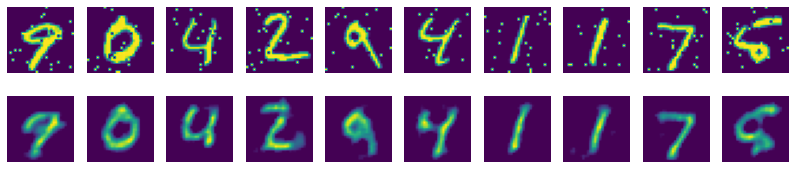

In [262]:
# corrupt test images with Salt and peper, pass them through AutoNN_SP 
# plot the results 

corrupted = util.random_noise(X_test, 's&p')
reconstruction = AutoNN_SP.predict(corrupted[0:10])
plot10(corrupted, reconstruction)

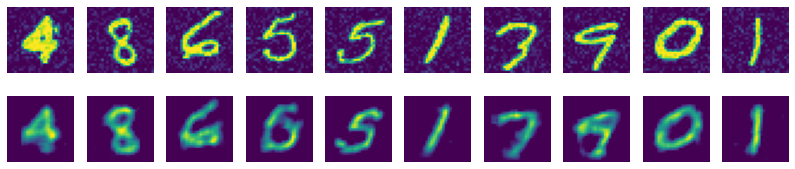

In [261]:
# corrupt test images with Gaussian noise, pass them through AutoNN_GN
# plot the results 

corrupted = util.random_noise(X_test, 'gaussian').astype(np.float32)
reconstruction = AutoNN_GN.predict(corrupted)

plot10(corrupted, reconstruction)